In [1]:
import numpy as np
from src.Preprocessing import create_labels_single_column
from src.Particle import ParticleType
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from src.BestEFPsFinder import BestEFPsFinder

In [2]:
# loading the data
efps_top = np.load("../../../Data/t_efps_d5_primed.npy")
efps_gluon = np.load("../../../Data/g_efps_d5_primed.npy")
efps_quark = np.load("../../../Data/q_efps_d5_primed.npy")

print(f"Number of Top Jets: {efps_top.shape[0]}")
print(f"Number of Gluon Jets: {efps_gluon.shape[0]}")
print(f"Number of LightQuark Jets: {efps_quark.shape[0]}")

Number of Top Jets: 177945
Number of Gluon Jets: 177252
Number of LightQuark Jets: 170679


In [3]:
# joinning the data 
# half of the data represents Top jets, the other half represents non-top quark jets
X = np.vstack((efps_top, efps_gluon[: int(efps_gluon.shape[0]/2)], efps_quark[: int(efps_quark.shape[0]/2)]))
y = create_labels_single_column(jet_inputs={ParticleType.Gluon: (efps_top.shape[0], X.shape[0] - 1), ParticleType.Top: (0, efps_top.shape[0] - 1)})
# shuffling the data
X, y = shuffle(X, y, random_state=42)

In [4]:
# Dividing the data into trainning, validation, and test
# diving the set into trainning, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

print(f"Size of the Training set: {X_train.shape[0]}")
print(f"Size of the Validation set: {X_val.shape[0]}")
print(f"Size of the Test set: {X_test.shape[0]}")

Size of the Training set: 269210
Size of the Validation set: 29913
Size of the Test set: 52787


In [5]:
dt_model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=70, random_state=0)
# dt_model.fit(X_train, y_train)

In [7]:
efps_finder = BestEFPsFinder(
    tree=dt_model, X_train=X_train[:, 0:20], y_train=y_train, X_val=X_val[:, 0:20], y_val=y_val
)

In [8]:
efps_finder.backward_elimination(accuracy_fraction_limit=0.99)

Best feature set is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
Accuracy is 0.882 (1.00% of model's accuracy 0.880)


KeyboardInterrupt: 

In [32]:
# Tranning set
y_train_predict = dt_model.predict(X_train)

print("Trainnig set:")
print(f"Recall for Quark tagging: {recall_score(y_train, y_train_predict):.2f}")
print(f"Precision for Quark tagging: {precision_score(y_train, y_train_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_train, y_train_predict, labels=[0, 1]))

Trainnig set:
Recall for Quark tagging: 0.91
Precision for Quark tagging: 0.88
Confusion Matrix
[[115928  16976]
 [ 12507 123799]]


In [34]:
y_val_predict = dt_model.predict(X_val)

print("Validation set:")
print(f"Recall for Quark tagging: {recall_score(y_val, y_val_predict):.2f}")
print(f"Precision for Quark tagging: {precision_score(y_val, y_val_predict):.2f}")
print("Confusion Matrix")
print(confusion_matrix(y_val, y_val_predict, labels=[0, 1]))

Validation set:
Recall for Quark tagging: 0.90
Precision for Quark tagging: 0.87
Confusion Matrix
[[12842  2041]
 [ 1567 13463]]


In [35]:
# evaluating the probabilities of each sample in the trainning data using 
# K-fold cross validation - it returns the probability of the sample in each class
y_probabilities = cross_val_predict(dt_model, X_train, y_train, cv=6, method='predict_proba')

AUC: 0.95


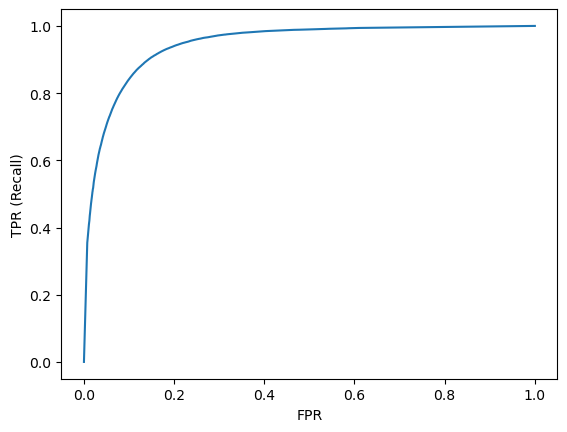

In [36]:
y_score = y_probabilities[:, 1]
plt.plot()
# roc curve for top tagging 
fpr, tpr, _ = roc_curve(y_train, y_score)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
print(f"AUC: {auc(fpr, tpr):.2f}")